# Data Loading 

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [ ]:
DATA_PATH = r"../data/"     # <-- change if needed
MODEL_DIR = "models"
MODEL_PATH = os.path.join(MODEL_DIR, "bodyfat_model.pkl")
FEATURES_PATH = os.path.join(MODEL_DIR, "bodyfat_features.pkl")

RANDOM_STATE = 42
TEST_SIZE = 0.2

In [37]:
print("Loading data...")
df = pd.read_csv(DATA_PATH)

print("First rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())

Loading data...
First rows:
   Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  Thigh  \
0   1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   59.0   
1   1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   58.7   
2   1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   59.6   
3   1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   60.1   
4   1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   63.2   

   Knee  Ankle  Biceps  Forearm  Wrist  
0  37.3   21.9    32.0     27.4   17.1  
1  37.3   23.4    30.5     28.9   18.2  
2  38.9   24.0    28.8     25.2   16.6  
3  37.3   22.8    32.4     29.4   18.2  
4  42.2   24.0    32.2     27.7   17.7  

Columns: ['Density', 'BodyFat', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']


In [38]:
print("\nShape before dropna:", df.shape)
df = df.dropna().reset_index(drop=True)
print("Shape after dropna:", df.shape)

# Optional: drop duplicates
# df = df.drop_duplicates().reset_index(drop=True)


Shape before dropna: (252, 15)
Shape after dropna: (252, 15)


In [39]:
# 2. Drop Density (not usable in UI and almost perfect predictor)
df = df.drop(columns=["Density"])

# 3. Define target and features
target_col = "BodyFat"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]


In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# VIF expects a numpy array
X_vif = X.astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = feature_cols
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

print(vif_data.sort_values("VIF", ascending=False))

    feature          VIF
6       Hip  1846.038409
12    Wrist  1253.945226
8      Knee  1126.127752
4     Chest  1116.522533
7     Thigh  1001.905412
3      Neck   969.617815
5   Abdomen   882.164599
11  Forearm   442.115878
10   Biceps   416.402292
2    Height   405.034542
9     Ankle   346.332442
1    Weight   248.597149
0       Age    30.861492


In [41]:
selected_features = [
    "Abdomen",   # strongest predictor
    "Weight",    # overall mass
    "Forearm",   # lowest VIF among arm features
    "Age",       # stable
    "Chest"      # secondary trunk predictor
]


In [42]:
selected_features = [f for f in selected_features if f in df.columns]

print("\nSelected features:", selected_features)
print("Target:", target_col)

X = df[selected_features]
y = df[target_col]
X, y


Selected features: ['Abdomen', 'Weight', 'Forearm', 'Age', 'Chest']
Target: BodyFat


(     Abdomen  Weight  Forearm  Age  Chest
 0       85.2  154.25     27.4   23   93.1
 1       83.0  173.25     28.9   22   93.6
 2       87.9  154.00     25.2   22   95.8
 3       86.4  184.75     29.4   26  101.8
 4      100.0  184.25     27.7   24   97.3
 ..       ...     ...      ...  ...    ...
 247     83.6  134.25     25.7   70   89.2
 248    105.0  201.00     28.6   72  108.5
 249    111.5  186.75     27.2   72  111.1
 250    101.3  190.75     29.4   72  108.3
 251    108.5  207.50     30.0   74  112.4
 
 [252 rows x 5 columns],
 0      12.3
 1       6.1
 2      25.3
 3      10.4
 4      28.7
        ... 
 247    11.0
 248    33.6
 249    29.3
 250    26.0
 251    31.9
 Name: BodyFat, Length: 252, dtype: float64)

In [43]:
# -----------------------------
# 5. Train / test split
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (201, 5)
Test shape: (51, 5)


In [44]:
# -----------------------------
# 6. Train model (Random Forest)
# -----------------------------

print("\nTraining RandomForestRegressor...")

model = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train, y_train)


Training RandomForestRegressor...


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
# -----------------------------
# 7. Evaluate model
# -----------------------------

y_pred = model.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MSE (no "squared" argument in older sklearn)
mse = mean_squared_error(y_test, y_pred)

# RMSE = sqrt(MSE)
rmse = np.sqrt(mse)

# R²
r2 = r2_score(y_test, y_pred)

print("\nPerformance on test set:")
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse}")
print(f"R²  : {r2}")


Performance on test set:
MAE : 3.5555490196078416
MSE : 17.928100838779944
RMSE: 4.234158811237474
R²  : 0.6145992116794157


# Visualization 


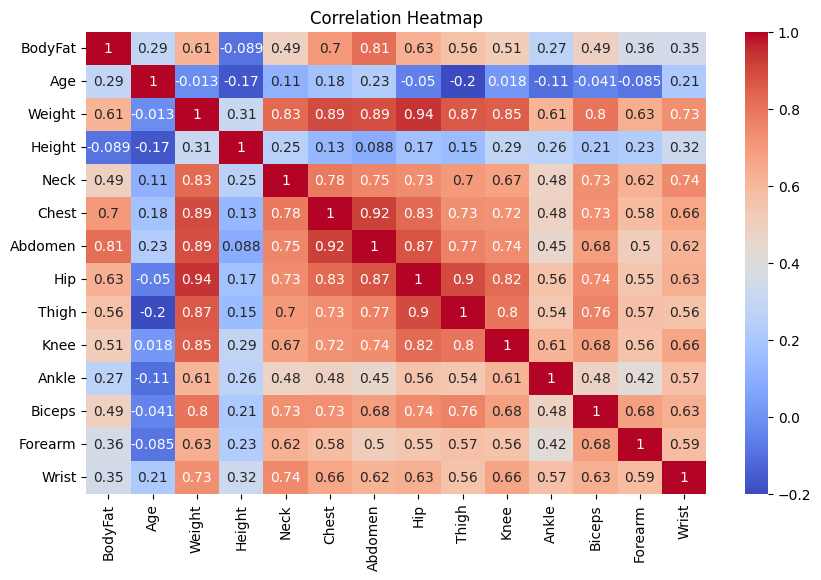

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [47]:
# 2. Drop Density (not usable in UI and almost perfect predictor)
df = df.drop(columns=["Density"])

# 3. Define target and features
target_col = "BodyFat"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]


KeyError: "['Density'] not found in axis"

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# VIF expects a numpy array
X_vif = X.astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = feature_cols
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

print(vif_data.sort_values("VIF", ascending=False))

    feature          VIF
6       Hip  1846.038409
12    Wrist  1253.945226
8      Knee  1126.127752
4     Chest  1116.522533
7     Thigh  1001.905412
3      Neck   969.617815
5   Abdomen   882.164599
11  Forearm   442.115878
10   Biceps   416.402292
2    Height   405.034542
9     Ankle   346.332442
1    Weight   248.597149
0       Age    30.861492


In [ ]:
selected_features = [
    'Age',
    'Weight',
    'Height',
    'Abdomen',
    'Chest',
    'Hip',
    'Thigh'
]

X = df[selected_features]
y = df['BodyFat']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 3.323777777777776
R²: 0.6385083473795421


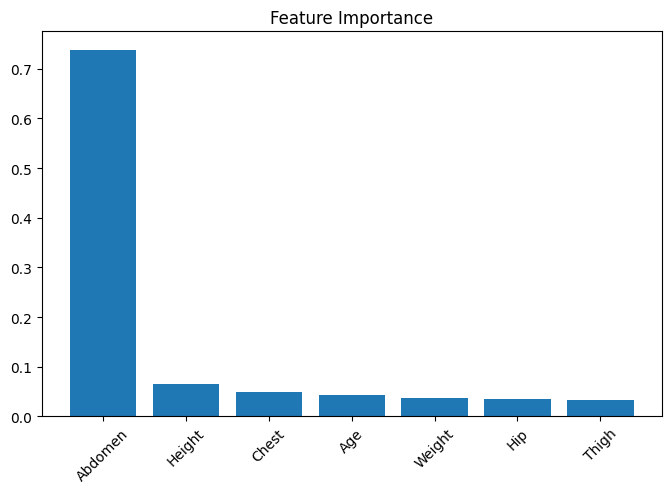

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(8,5))
plt.bar([selected_features[i] for i in indices], importances[indices])
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.show()


NameError: name 'st' is not defined